In [4]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Import the dataset from working directory
data = pd.read_csv('email.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
# Some information about the dataset
data.shape
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


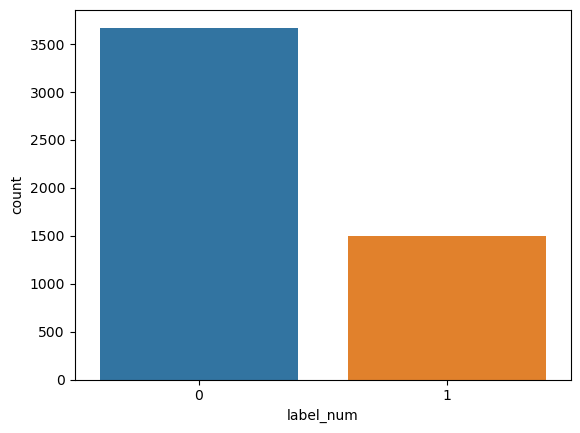

In [7]:
# Plot the counts of the dataset
sns.countplot(data=data, x='label_num')
plt.show()

In [8]:
# Store labels of the dataset according to their labels
# access dataset -> dataset column "x" -> values of y
ham_msgs = data[data["label_num"]==0]
spam_msgs = data[data["label_num"]==1]
print(ham_msgs)
print(spam_msgs)


      Unnamed: 0 label                                               text  \
0            605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1           2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2           3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
4           2030   ham  Subject: re : indian springs\r\nthis deal is t...   
5           2949   ham  Subject: ehronline web address change\r\nthis ...   
...          ...   ...                                                ...   
5165        2849   ham  Subject: fw : crosstex energy , driscoll ranch...   
5166        1518   ham  Subject: put the 10 on the ft\r\nthe transport...   
5167         404   ham  Subject: 3 / 4 / 2000 and following noms\r\nhp...   
5168        2933   ham  Subject: calpine daily gas nomination\r\n>\r\n...   
5169        1409   ham  Subject: industrial worksheets for august 2000...   

      label_num  
0             0  
1             0  
2             0  
4  

In [9]:
# Notice that Ham and Spam have different num. of samples
# Downsample to balance the dataset
ham_msgs=ham_msgs.sample(len(spam_msgs),random_state=42)
print(ham_msgs)
print(spam_msgs)

      Unnamed: 0 label                                               text  \
2977        3444   ham  Subject: conoco - big cowboy\r\ndarren :\r\ni ...   
3822        2982   ham  Subject: feb 01 prod : sale to teco gas proces...   
2257        2711   ham  Subject: california energy crisis\r\ncaliforni...   
2786        3116   ham  Subject: re : nom / actual volume for april 23...   
4551        1314   ham  Subject: eastrans nomination changes effective...   
...          ...   ...                                                ...   
2877        3370   ham  Subject: fw : duke energy trading and marketin...   
3010         180   ham  Subject: re : greatwood gas\r\nthanks , kyle ....   
1893         686   ham  Subject: tufco\r\nmy est . for tufco is the sa...   
1106         472   ham  Subject: mobil discrepancies\r\ndaren :\r\ni '...   
4618        1525   ham  Subject: cornhusker for sept\r\ncorrection : t...   

      label_num  
2977          0  
3822          0  
2257          0  
278

Text(0.5, 0, 'Message Types')

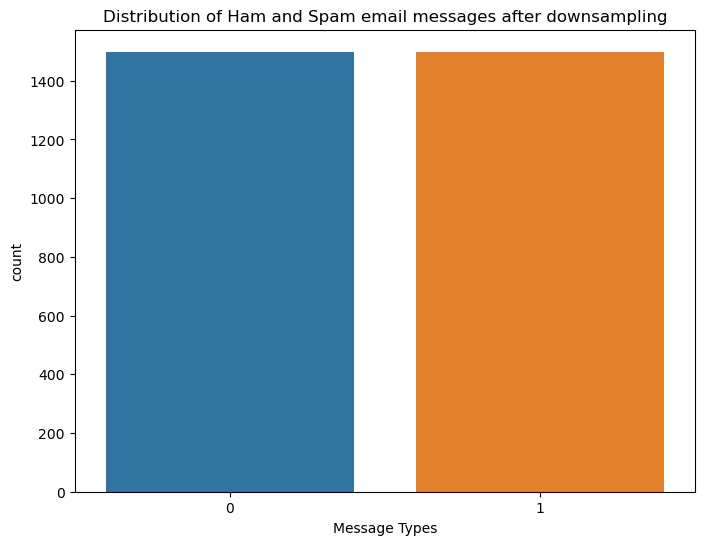

In [10]:
# Replot the counts of the dataset for visual
# Join the Ham and Spam dataset variables
balanced_data = ham_msgs.append(spam_msgs)\
    .reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(data=balanced_data, x='label_num')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message Types')

# Text Preprocessing
Lets clean the data.
- remove stopwords
- remove punctuations
- stemming or lemmatization

In [11]:
# Remove the 'Subject' text of emails in the data set.
# Replace it with '' (delete)
balanced_data['text'] = balanced_data['text'].str.replace('Subject:', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco - big cowboy\r\ndarren :\r\ni ' m not ...,0
1,2982,ham,feb 01 prod : sale to teco gas processing\r\n...,0
2,2711,ham,"california energy crisis\r\ncalifornia  , s ...",0
3,3116,ham,re : nom / actual volume for april 23 rd\r\nw...,0
4,1314,ham,eastrans nomination changes effective 8 / 2 /...,0


# Function: Remove punctuations

## maketrans = str.maketrans( str1,str2,str3 )
construct transition table (chars to be deleted)
    str1: list of chars needed to be replaced
    str2: list of chars which will replace them
    str3: list of chars that needs deletion
    rtn -> translation table which specifies conversions used by translate()
## x.translate( table, delstr )
where x is the list to translate

## custom table
table = { x1:y1, x2:y2:, x3:y3:, x4:None }

In [12]:
punctuations_list = string.punctuation

# Make a function to remove punctuations and return it
def remove_punctuations(text):
    # construct transition table (chars to be deleted)
        #str1: list of chars needed to be replaced
        #str2: list of chars which will replace them
        #str3: list of chars that needs deletion
        #rtn -> translation table which specifies conversions used by translate()
    temp = str.maketrans('','',punctuations_list)
    return text.translate(temp)

# Apply the function to the specific column in the dataset,'text'
balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


# Function: Remove stopwords

In [13]:
def remove_stopwords(text):
    # store stopwords in a variable
    stop_words = stopwords.words('english')
    imp_words = []
    
    # loop to find important words
    for word in str(text).split():
        word = word.lower()       # convert to lowercase
        
        if word not in stop_words:
            imp_words.append(word) # store important words
    
    # store the important words in a variable separate by spaces
    output = " ".join(imp_words)
    return output

# Lambdas
- lambda functions in python are small anonymous functions
- can take any # of arguments and execute an expression

In [14]:
balanced_data['text'] = balanced_data['text'].apply(
    lambda text: remove_stopwords(text) )
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


# Function: Word Cloud
text visualization tool that help's us to get insights into the most frequent words present in the corpus of the data.

In [15]:
def plot_word_cloud(data, typ):
    # create a corpus to store the email messages
    email_corpus = " ".join(data['text'])
    
    plt.figure( figsize=(7,7) )
    
    # generate a word cloud for the corpus
    wc = WordCloud(background_color='black',
                  max_words=100,
                  width=800,
                  height=400,
                  collocations=False).generate(email_corpus)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

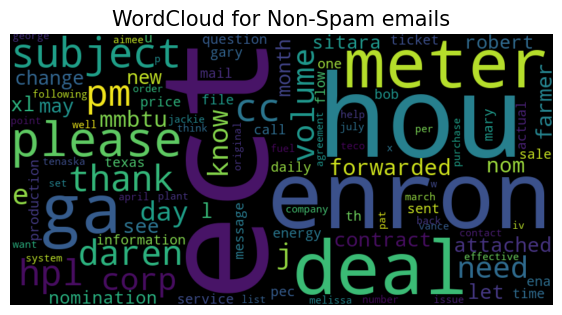

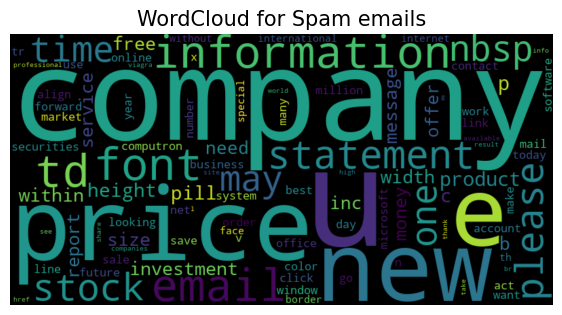

In [16]:
plot_word_cloud(balanced_data[balanced_data['label_num'] == 0],
                typ = 'Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label_num'] == 1],
                typ = 'Spam')

# Word2Vec

words are strings - machine learning models only work on numbers. 

Text Vectorization: convert words to VECTORS with token IDs (numbers) to corresponding words.
- tokenizers split text data into 'tokens' which are separated words, punctuations, numbers, dates, etc.

https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/
Word Embedding: dense representation where words or phrases with similar meaning are closer in vector space.
Vectorization of words or phrases as word embeddings facilitate estimation of semantic similarities between different text materials.

After "padding" of textual data, it can be fed into a model.

First vectorize on the whole training data
then split between train and test vectors

# Sequences
allows multiple values stored in order - sequential data.
eg. dictionaries and sets are containers for sequential data
    - Lists (mutable)
    - Tuples (immutable)
    - Strings (characters)

eg. [a,b,c,d...]
    opperations: [a,b,c] + [d,e,f] = [a+d,b+e,c+f]
    
# Padding
https://saturncloud.io/blog/padding-sequences-of-2d-elements-in-keras-a-comprehensive-guide/
since sequential data vary in lengths, they need to be padded to ensure a given batch all have the same length.
deep learning requires fixed-length input.


# Train, Test, Split
Split arrays or matrices into random train and test subsets. 

`sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)`

where *arrays is typically:
(x data, corresponding y data)


## Train and Test X = text emails
## Train and Test Y = feature labels

In [18]:
# Split the data into Training Sets and Test sets
train_X_str, test_X_str, train_Y, test_Y = train_test_split( 
    balanced_data['text'], # x vals (str)
    balanced_data['label_num'], # y vals (ints)
    test_size = 0.2,
    random_state = 42 )

In [19]:
# Initialize a tokenizer and fit it on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X_str)

# Create sequences for training and testing data
train_X = tokenizer.texts_to_sequences(train_X_str)
test_X = tokenizer.texts_to_sequences(test_X_str)

# Pad sequences
max_len = 100
train_X = pad_sequences( train_X, 
                         max_len,
                        padding = 'post',
                        truncating = 'post')

test_X = pad_sequences( test_X,
                       max_len,
                       padding = 'post',
                       truncating = 'post')

# The Sequential Model
The sequential model contains:

- 3 Embedding Layers: to learn featured vector representations of the input vectors.
- LSTM (Long Short Term Memory) layer: to identify useful patterns in the sequence.
- Have one fully connected layer.
- Output a final layer which have the probabilities for the test data belonging to certain classes.

# Embedded Layer / Word Embedding
https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding

https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
converts each word into a fixed length vector of defined size.

one-hot encoding: converts features (of any size) into word vectors of varying dimensions.

Converting word vectors to a defined fixed size is more efficient as it reduces the number of dimensions.

`tf.keras.layers.Embedding( input_dim: size of vocab, 
                            output_dim: length of each word vector,
                            input_length: max length of a sequence )`
                            
*numbers are encoded according to input_dim

the output is represented generally as
[[  [ a0, ..., an ]      word 1
    [ b0, ..., bn ] ]    word 2 ....
    
where 
each row = a word
number of rows = input_dim
number of columns = output_dim

weights represent vector representations of the words in vocabulary

# Build the Model

In [20]:
model = tf.keras.models.Sequential()

# Add an embedded layer
model.add( tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length = max_len) )
model.add( tf.keras.layers.LSTM(16) )
model.add( tf.keras.layers.Dense(32, activation='relu') )
model.add( tf.keras.layers.Dense(1, activation='sigmoid') )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1274912   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,278,625
Trainable params: 1,278,625
Non-trainable params: 0
_________________________________________________________________


2023-07-19 14:53:50.896011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-19 14:53:50.900356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-19 14:53:50.902538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# Compile the Model
Three parameters are involved:

1) Optimizer: Method helps optimize the cost function by using gradient descent (slope)

2) Loss: Loss function by which we monitor whether the model is improving with training or not.

3) Metrics: Helps evaluate the model by predicting the test data and compare validity.

In [22]:
model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics = ['accuracy'],
             optimizer = 'adam')

# Callbacks
Callbacks allow us to see whether the model is improving with each epoch or not.

## ReduceLROnPlateau
`tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
    **kwargs
)`

- factor: factor by which lr to be reduced 
- patience: number of epochs with no improvement after which learning rate will be reduced.

Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.

## EarlyStopping
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
`tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)`

Early stopping stops training when a monitored metric has stopped improving.

In [23]:
es = EarlyStopping( patience = 3,
                  monitor = 'val_accuracy',
                  restore_best_weights = True )

lr = ReduceLROnPlateau( patience = 2,
                      monitor = 'val_loss',
                      factor = 0.5,
                      verbose = 0 )

# Train the Model - Apply Train Sets

In [25]:
# Fit the model by training with X and Y Training Data

history = model.fit(
    train_X, train_Y,
    epochs = 20,
    batch_size = 32,
    callbacks = [lr,es] )

Epoch 1/20
75/75 [==============================] - 2s 23ms/step - loss: 0.5272 - accuracy: 0.7790 - lr: 5.0000e-04
Epoch 2/20
75/75 [==============================] - 2s 24ms/step - loss: 0.5068 - accuracy: 0.7235 - lr: 5.0000e-04
Epoch 3/20
75/75 [==============================] - 2s 23ms/step - loss: 0.4747 - accuracy: 0.7515 - lr: 5.0000e-04
Epoch 4/20
75/75 [==============================] - 2s 23ms/step - loss: 0.2831 - accuracy: 0.8878 - lr: 5.0000e-04
Epoch 5/20
75/75 [==============================] - 2s 23ms/step - loss: 0.1003 - accuracy: 0.9779 - lr: 5.0000e-04
Epoch 6/20
75/75 [==============================] - 2s 24ms/step - loss: 0.0911 - accuracy: 0.9779 - lr: 5.0000e-04
Epoch 7/20
75/75 [==============================] - 2s 24ms/step - loss: 0.0900 - accuracy: 0.9779 - lr: 5.0000e-04
Epoch 8/20
75/75 [==============================] - 2s 25ms/step - loss: 0.0895 - accuracy: 0.9779 - lr: 5.0000e-04
Epoch 9/20
75/75 [==============================] - 2s 26ms/step - loss:

75/75 [==============================] - 2s 22ms/step - loss: 0.0850 - accuracy: 0.9779 - lr: 5.0000e-04
Epoch 19/20
75/75 [==============================] - 2s 23ms/step - loss: 0.0841 - accuracy: 0.9779 - lr: 5.0000e-04
Epoch 20/20
75/75 [==============================] - 2s 27ms/step - loss: 0.0886 - accuracy: 0.9762 - lr: 5.0000e-04


# Evaluate the Model - Apply Test Sets
Use the validation sets (tests) to evaluate the accuracy of our model.

In [26]:
test_loss, test_accuracy = model.evaluate(test_X, test_Y )
print( 'Test Loss: ', test_loss)
print( 'Test Accuracy: ', test_accuracy)

19/19 [==============================] - 0s 5ms/step - loss: 0.1350 - accuracy: 0.9633
Test Loss:  0.1350494921207428
Test Accuracy:  0.9633333086967468


# History Keys
The results of the evaluation are stored in keys

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'lr'])


# Visualize the Results

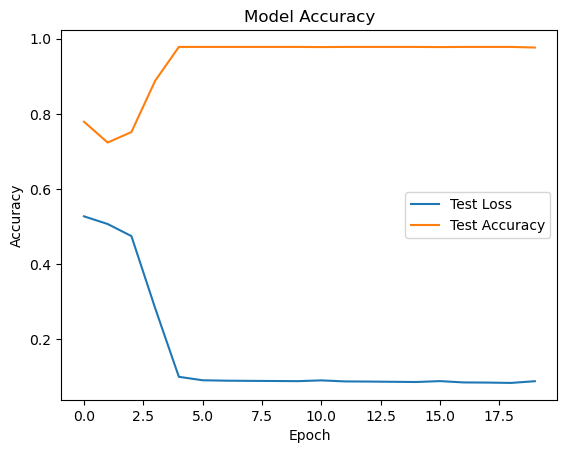

In [29]:
plt.plot(history.history['loss'], label = 'Test Loss')
plt.plot(history.history['accuracy'], label = 'Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predict Single Samples

In [33]:
pred_1 = test_X[4:5]
pred_1_str = test_X_str[4:5]

print("\nPrediction:")
print(pred_1_str)

print("\nEpoch Prediction:")
pred_1_result = model.predict(pred_1)

print("\nPrediction Result:")
print(np.argmax(pred_1_result))

print("\nValidation Answer:")
print(test_Y[4:5])

print("\nAccuracy:")
test_loss, test_acc = model.evaluate(test_X[4:5], test_Y[4:5], verbose=2)
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)


Prediction:
51    fw first delivery rodessa operating co daren t...
Name: text, dtype: object

Epoch Prediction:
1/1 [==============================] - 0s 22ms/step

Prediction Result:
0

Validation Answer:
51    0
Name: label_num, dtype: int64

Accuracy:
1/1 - 0s - loss: 3.9030e-04 - accuracy: 1.0000 - 20ms/epoch - 20ms/step
Test Accuracy:  1.0
Test Loss:  0.0003902987518813461
